This notebook is for ML operon prediction

In [6]:
import pandas as pd

# Read the ML data
ml_data = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/ML/tu_input_for_ml_term.tsv", sep="\t").drop("Unnamed: 0", axis=1).set_index('Protein ID')
display(ml_data)

# Print data summary
ml_data.describe()

,Distance to IUN,Operonic to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN,Upstream Terminator
Protein ID,,,,,,
pgap_GCF_000220135.1_000002,575,0,0.043,0.738,0.735,1
pgap_GCF_000220135.1_000005,134,0,0.043,NaN,NaN,0
pgap_GCF_000220135.1_000006,174,1,0.043,0.845,0.901,0
pgap_GCF_000220135.1_000007,68,1,0.043,NaN,NaN,0
pgap_GCF_000220135.1_000012,105,0,0.478,NaN,NaN,0
...,...,...,...,...,...,...
pgap_GCF_000220135.1_002084,123,1,0.130,NaN,NaN,0
pgap_GCF_000220135.1_002085,122,1,0.130,NaN,NaN,0
pgap_GCF_000220135.1_002086,-1,1,0.000,NaN,NaN,0


,Distance to IUN,Operonic to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN,Upstream Terminator
count,581.000000,581.000000,528.000000,255.000000,255.000000,581.000000
mean,105.972461,0.710843,0.132557,0.519325,0.511000,0.113597
std,127.496069,0.453761,0.204587,0.299486,0.344129,0.317595
min,-53.000000,0.000000,0.000000,0.098000,0.017000,0.000000
25%,15.000000,0.000000,0.000000,0.278500,0.186500,0.000000
50%,79.000000,1.000000,0.043000,0.401000,0.504000,0.000000
75%,151.000000,1.000000,0.217000,0.795500,0.861500,0.000000
max,1308.000000,1.000000,1.000000,1.000000,1.000000,1.000000


First, try to teach a model based on all features (distance to IUN, phylogenetic distance, semantic similarity and presence of upstream terminator):

In [93]:
# Random Forest Classifier with cross-validation

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix)

pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, random_state=0))
])

# 1) Get out‑of‑fold probabilities
proba = cross_val_predict(
    pipeline, X, y,
    cv=5,
    method='predict_proba') # predict_proba returns an array of shape (n_samples, n_classes)

# print(proba)
pos_proba = proba[:, 1] # [:,0] = P(class=0), [:,1] = P(class=1)

# 2) Get out‑of‑fold class predictions (threshold = 0.5)
y_pred = (pos_proba >= 0.5).astype(int)
y = y.to_numpy()

# 3) Compute metrics on the whole dataset using OOF predictions
acc   = accuracy_score(y, y_pred)
prec  = precision_score(y, y_pred)
rec   = recall_score(y, y_pred)
f1    = f1_score(y, y_pred)
auc   = roc_auc_score(y, pos_proba)
ll    = log_loss(y, pos_proba)
brier = brier_score_loss(y, pos_proba)
cm    = confusion_matrix(y, y_pred)

print(f"CV Accuracy:         {acc:.3f}")
print(f"CV Precision:        {prec:.3f}")
print(f"CV Recall:           {rec:.3f}")
print(f"CV F1‐Score:         {f1:.3f}")
print(f"CV ROC AUC:          {auc:.3f}")
print(f"CV Log‐Loss:         {ll:.3f}")
print(f"CV Brier Score:      {brier:.3f}")
print("CV Confusion Matrix:\n", cm)


CV Accuracy:         0.819
CV Precision:        0.867
CV Recall:           0.881
CV F1‐Score:         0.874
CV ROC AUC:          0.893
CV Log‐Loss:         0.497
CV Brier Score:      0.125
CV Confusion Matrix:
 [[112  56]
 [ 49 364]]


In [91]:
# Select The Prediction Target
y = ml_data["Operonic to IUN"]

# Select Features
ml_features = ["Distance to IUN", "Hamming Distance to IUN", "GOntoSim Similarity to IUN", "Wang Similarity to IUN", "Upstream Terminator"]
X = ml_data[ml_features]
display(X)

,Distance to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN,Upstream Terminator
Protein ID,,,,,
pgap_GCF_000220135.1_000002,575,0.043,0.738,0.735,1
pgap_GCF_000220135.1_000005,134,0.043,NaN,NaN,0
pgap_GCF_000220135.1_000006,174,0.043,0.845,0.901,0
pgap_GCF_000220135.1_000007,68,0.043,NaN,NaN,0
pgap_GCF_000220135.1_000012,105,0.478,NaN,NaN,0
...,...,...,...,...,...
pgap_GCF_000220135.1_002084,123,0.130,NaN,NaN,0
pgap_GCF_000220135.1_002085,122,0.130,NaN,NaN,0
pgap_GCF_000220135.1_002086,-1,0.000,NaN,NaN,0


In [89]:
# Gini feature importance

# After fitting your pipeline on all data:
pipeline.fit(X, y)

# Extract the fitted RandomForest
rf = pipeline.named_steps['model']

# Get raw importances and pair with feature names
importances = rf.feature_importances_
feat_names   = X.columns  # or however you store your column names

# Sort descending
indices = importances.argsort()[::-1]
for idx in indices:
    print(f"{feat_names[idx]:26s}  →  {importances[idx]:.4f}")

Distance to IUN             →  0.5958
Hamming Distance to IUN     →  0.1500
Upstream Terminator         →  0.0970
GOntoSim Similarity to IUN  →  0.0873
Wang Similarity to IUN      →  0.0698


In [92]:
# Gini importance with cross-validation

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Prepare your pipeline (same as before)
pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, random_state=0))
])

# Set up 5‑fold stratified CV
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Will hold the feature_importances_ from each fold
all_importances = []

for train_idx, _ in kf.split(X, y):
    # Fit only on the train‐portion of each fold
    X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
    pipeline.fit(X_tr, y_tr)

    # Extract the fitted RF and its importances
    rf = pipeline.named_steps['model']
    all_importances.append(rf.feature_importances_)

# Convert to array for easy aggregation
importances_arr = np.vstack(all_importances)   # shape = (n_folds, n_features)

# Compute mean and std across folds
mean_imp = importances_arr.mean(axis=0)
std_imp  = importances_arr.std(axis=0)

# Pair with feature names and sort descending
feat_names = X.columns
indices = mean_imp.argsort()[::-1]

for idx in indices:
    print(f"{feat_names[idx]:26s} → {mean_imp[idx]:.4f} ± {std_imp[idx]:.4f}") # 26s limits str length to 26 symbols

Distance to IUN            → 0.5940 ± 0.0074
Hamming Distance to IUN    → 0.1544 ± 0.0093
GOntoSim Similarity to IUN → 0.0881 ± 0.0070
Upstream Terminator        → 0.0867 ± 0.0076
Wang Similarity to IUN     → 0.0768 ± 0.0043


In [ ]:
# Permutation feature importance

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# 1) Split off a hold‑out set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
pipeline.fit(X_train, y_train)

# 2) Compute permutation importances on the held‑out set
results = permutation_importance(
    pipeline, X_val, y_val,
    n_repeats=30,
    random_state=0,
    scoring='balanced_accuracy'   # or 'roc_auc', etc.
)

# 3) Display sorted
perm_importances = results.importances_mean
indices = perm_importances.argsort()[::-1]
for idx in indices:
    mean_imp = perm_importances[idx]
    std_imp  = results.importances_std[idx]
    print(f"{feat_names[idx]:20s}  →  {mean_imp:.4f} ± {std_imp:.4f}")

In [87]:
# Permutation importance with cross-validation

from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
all_importances = []

for train_idx, val_idx in kf.split(X, y):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(X_tr, y_tr)

    # e.g. permutation importance on the hold‑out fold
    res = permutation_importance(rf, X_val, y_val, n_repeats=10, random_state=0)
    all_importances.append(res.importances_mean)

all_importances = np.array(all_importances)
mean_imp = np.mean(all_importances, axis=0)
std_imp  = np.std(all_importances, axis=0)

for name, m, s in zip(X.columns, mean_imp, std_imp):
    print(f"{name:26s} → {m:.3f} ± {s:.3f}")

Distance to IUN            → 0.155 ± 0.020
Hamming Distance to IUN    → 0.029 ± 0.021
GOntoSim Similarity to IUN → 0.008 ± 0.012
Wang Similarity to IUN     → 0.006 ± 0.007
Upstream Terminator        → 0.021 ± 0.005


Since semantic similarity has low significance, it is necessary to try to remove these columns and evaluate the model based on intergenic distance, phylogenetic distances and the presence of a terminator:

In [97]:
# Select The Prediction Target
y = ml_data["Operonic to IUN"]
display(y)

# Select Features
ml_features = ["Distance to IUN", "Hamming Distance to IUN", "Upstream Terminator"]
X = ml_data[ml_features]
display(X)

Protein ID
pgap_GCF_000220135.1_000002    0
pgap_GCF_000220135.1_000005    0
pgap_GCF_000220135.1_000006    1
pgap_GCF_000220135.1_000007    1
pgap_GCF_000220135.1_000012    0
                              ..
pgap_GCF_000220135.1_002084    1
pgap_GCF_000220135.1_002085    1
pgap_GCF_000220135.1_002086    1
pgap_GCF_000220135.1_002087    1
pgap_GCF_000220135.1_002088    1
Name: Operonic to IUN, Length: 581, dtype: int64

,Distance to IUN,Hamming Distance to IUN,Upstream Terminator
Protein ID,,,
pgap_GCF_000220135.1_000002,575,0.043,1
pgap_GCF_000220135.1_000005,134,0.043,0
pgap_GCF_000220135.1_000006,174,0.043,0
pgap_GCF_000220135.1_000007,68,0.043,0
pgap_GCF_000220135.1_000012,105,0.478,0
...,...,...,...
pgap_GCF_000220135.1_002084,123,0.130,0
pgap_GCF_000220135.1_002085,122,0.130,0
pgap_GCF_000220135.1_002086,-1,0.000,0


In [98]:
# Random Forest Classifier with cross-validation (3 features)

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix)

pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, random_state=0))
])

# 1) Get out‑of‑fold probabilities
proba = cross_val_predict(
    pipeline, X, y,
    cv=5,
    method='predict_proba') # predict_proba returns an array of shape (n_samples, n_classes)

# print(proba)
pos_proba = proba[:, 1] # [:,0] = P(class=0), [:,1] = P(class=1)

# 2) Get out‑of‑fold class predictions (threshold = 0.5)
y_pred = (pos_proba >= 0.5).astype(int)
y = y.to_numpy()

# 3) Compute metrics on the whole dataset using OOF predictions
acc   = accuracy_score(y, y_pred)
prec  = precision_score(y, y_pred)
rec   = recall_score(y, y_pred)
f1    = f1_score(y, y_pred)
auc   = roc_auc_score(y, pos_proba)
ll    = log_loss(y, pos_proba)
brier = brier_score_loss(y, pos_proba)
cm    = confusion_matrix(y, y_pred)

print(f"CV Accuracy:         {acc:.3f}")
print(f"CV Precision:        {prec:.3f}")
print(f"CV Recall:           {rec:.3f}")
print(f"CV F1‐Score:         {f1:.3f}")
print(f"CV ROC AUC:          {auc:.3f}")
print(f"CV Log‐Loss:         {ll:.3f}")
print(f"CV Brier Score:      {brier:.3f}")
print("CV Confusion Matrix:\n", cm)

CV Accuracy:         0.818
CV Precision:        0.858
CV Recall:           0.891
CV F1‐Score:         0.874
CV ROC AUC:          0.873
CV Log‐Loss:         0.814
CV Brier Score:      0.134
CV Confusion Matrix:
 [[107  61]
 [ 45 368]]


[0.4243885956183968, 0.40746972160831296, 0.39508350592756425, 0.3979395481028522, 0.4009805213532528, 0.402730105907013, 0.4020162886063792, 0.4052836976576502, 0.40367391929602403, 0.40773402598152536, 0.40377675555129966, 0.4002488909065671, 0.40080219810214257, 0.4048641281624593, 0.4045808112011883, 0.40506021333205566, 0.4076600616688944, 0.4076351818342148, 0.40864200297135567, 0.40864656190902704, 0.4090915572143798, 0.4076161611076476, 0.4078786338938699, 0.40895751913990763, 0.40886222817367157, 0.40774474368711944, 0.4098753341107698, 0.4085744726669196, 0.40883991779144313, 0.40961744141386786, 0.4107887791798731, 0.40931171829543755, 0.41084126995968506, 0.411604718984102, 0.41152306638669606, 0.4114217577902246, 0.4114225724003892, 0.41182447779641607, 0.4119271053125896, 0.4120482797355156, 0.40890076706163114, 0.40701662519199105, 0.4069775502715639, 0.40686713256536367, 0.40546450300275844, 0.4051508420114813, 0.40519727193203164, 0.4034473768917737, 0.4035603982482075

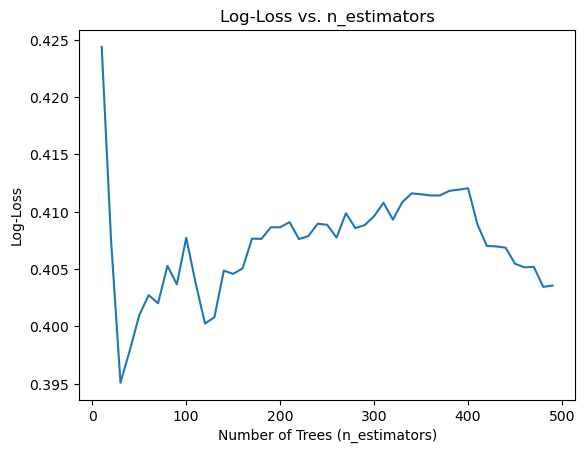

In [101]:
# Find n_estimators plato

rf = RandomForestClassifier(warm_start=True, random_state=0) # warm_start=True tells the RandomForestClassifier to reuse the trees it already built (each time only 10 more trees are created)

errors = []
n_estimators_list = []
for n in range(10, 500, 10):
    n_estimators_list.append(n)
    rf.set_params(n_estimators=n)
    rf.fit(train_X, train_y)
    proba = rf.predict_proba(val_X)[:,1]
    errors.append(log_loss(val_y, proba))
print(errors)

# Plot n vs. errors to find where it flattens out.
plt.plot(n_estimators_list, errors)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Log-Loss")
plt.title("Log-Loss vs. n_estimators")
plt.show()

[1.4789391155445717, 0.4395048686890971, 0.4643402835911271, 0.45667867953288244, 0.4453838145180872, 0.4446163122025041, 0.4267734247202573, 0.4231089788537852, 0.4215306586016052, 0.41845910777349504, 0.4147858855065166, 0.4148712967216542, 0.4198652014066747, 0.4202989272159705, 0.42068081832030796, 0.42546228764734595, 0.42348259186007337, 0.42477211307916696, 0.42117125297042607, 0.42274395857047087, 0.4213547530603079, 0.4227009894367505, 0.42235737444486987, 0.42343388818809446, 0.42148736599630215, 0.4200491887328402, 0.4195579257599843, 0.42097767489773047, 0.42196263724110583, 0.4211237503388069, 0.4180128728329363, 0.4190492593946432, 0.4188574937925906, 0.41797213832119495, 0.4179606767702815, 0.41675311495762624, 0.41698865936172735, 0.4153170848206532, 0.41491334612918784, 0.4158290843285335, 0.41569080705808975, 0.4153850283358227, 0.415612184757212, 0.41292868825094253, 0.41169052431490116, 0.41193316110698597, 0.41266236138528445, 0.4113524240259899, 0.4116223091874195

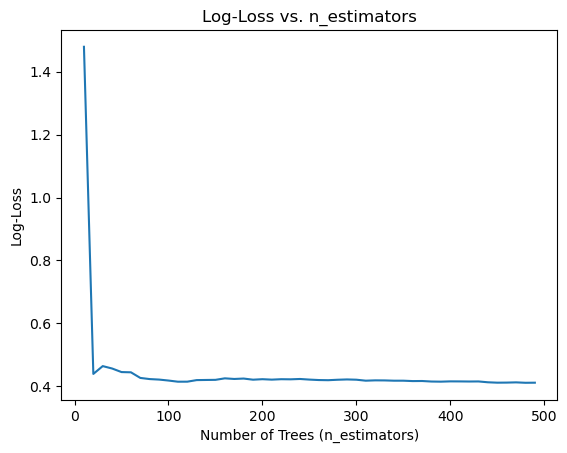

In [106]:
# Find n_estimators plato (fresh forests)

rf = RandomForestClassifier(warm_start=False, random_state=1)

errors = []
n_estimators_list = []
for n in range(10, 500, 10):
    n_estimators_list.append(n)
    rf.set_params(n_estimators=n)
    rf.fit(train_X, train_y)
    proba = rf.predict_proba(val_X)[:,1]
    errors.append(log_loss(val_y, proba))
print(errors)

# Plot n vs. errors to find where it flattens out.
plt.plot(n_estimators_list, errors)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Log-Loss")
plt.title("Log-Loss vs. n_estimators")
plt.show()

Once the number of trees in the forest reaches n-estimators=100, the log-loss stops decreasing and reaches a plateau. Therefore, n-estimators=100 is a sufficient number of trees in the forest. Further increasing this parameter will not improve the quality of the model.

In [119]:
# Check rows with fake predictions

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

# Select The Prediction Target
y = ml_data["Operonic to IUN"]

# Select Features
ml_features = ["Distance to IUN", "Hamming Distance to IUN", "GOntoSim Similarity to IUN", "Wang Similarity to IUN", "Upstream Terminator"]
X = ml_data[ml_features]
# display(X)

# Assume X is a DataFrame and y is a Series or array
pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, random_state=0))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) # shuffle 

# To store misclassified rows
bad_rows = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1): # cv.split(X, y) returns a generator that, on each iteration, yields a tuple (train_idx, test_idx); fold is the fold number (1 through n_splits)
    # print(fold, (train_idx, test_idx))
    # Split
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit
    pipeline.fit(X_tr, y_tr)
    
    # Predict proba and hard labels on this fold’s validation set
    proba = pipeline.predict_proba(X_te)[:, 1]
    y_pred = (proba >= 0.5).astype(int)
    
    # Find misclassifications in this fold
    mask_bad = (y_pred != y_te)
    
    # Slice out those rows from X_te
    df_bad = X_te[mask_bad].copy()
    df_bad['y_true']   = y_te[mask_bad]
    df_bad['y_pred']   = y_pred[mask_bad]
    df_bad['proba']    = proba[mask_bad]
    # df_bad['fold']     = fold
    
    bad_rows.append(df_bad)

# Concatenate all bad rows into one DataFrame
misclassified = pd.concat(bad_rows)
misclassified = misclassified.drop("fold", axis=1).sort_values(by="y_true")

# Inspect
print(f"Total misclassified across all folds: {len(misclassified)}")
display(misclassified)
misclassified.to_csv("/home/msdyachkova/data15/bifido/operon_prediction/ML/misclassified.tsv", sep="\t")

Total misclassified across all folds: 101


,Distance to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN,Upstream Terminator,y_true,y_pred,proba
Protein ID,,,,,,,,
pgap_GCF_000220135.1_000237,90,NaN,NaN,NaN,0,0,1,0.592333
pgap_GCF_000220135.1_000272,148,0.043,NaN,NaN,0,0,1,0.910000
pgap_GCF_000220135.1_001081,156,0.087,NaN,NaN,0,0,1,0.840000
pgap_GCF_000220135.1_001391,87,0.565,NaN,NaN,0,0,1,0.778333
pgap_GCF_000220135.1_001274,202,0.043,NaN,NaN,0,0,1,0.982500
...,...,...,...,...,...,...,...,...
pgap_GCF_000220135.1_001164,131,0.000,NaN,NaN,0,1,0,0.090000
pgap_GCF_000220135.1_001193,205,0.087,0.378,0.546,0,1,0,0.340000
pgap_GCF_000220135.1_001070,191,0.043,NaN,NaN,1,1,0,0.320000


In [ ]:
# Parameters tuning (Setting up a GridSearchCV)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('model', RandomForestClassifier(random_state=0))
])

param_grid = {
    'model__max_features': [1, 2, 3, 4, None],
    'model__max_depth': [2, 6, 10, None],
    'model__min_samples_leaf': [1, 2, 5, 10, 0.05, 0.1],
    'model__min_samples_split': [2, 5, 10, 0.05, 0.1, 0.2],
    'model__bootstrap': [True, False]
}

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_inner,
    # scoring="f1",   # or 'balanced_accuracy' if positives/negatives equally important
    scoring="balanced_accuracy",
    n_jobs=-1,
    # verbose=2
)

grid.fit(X, y)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Balanced accuracy is (TPR+TNR)/2, the average of sensitivity and specificity.
It treats the positive and negative classes exactly equally, rewarding parameter settings that do well on both.

Balanced accuracy:
Best params: {'model__bootstrap': True, 'model__max_depth': 2, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 0.2}
Best CV score: 0.8104629290607062

In [1]:
# Select The Prediction Target

import pandas as pd

ml_data = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_prom.tsv", sep="\t").set_index("Protein ID")

y = ml_data["Operonic to IUN"]

# Select Features
ml_features = ["Distance to IUN", "Hamming Distance to IUN", "GOntoSim Similarity to IUN", "Wang Similarity to IUN", "Upstream Terminator"]
X = ml_data[ml_features]
display(X)

,Distance to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN,Upstream Terminator
Protein ID,,,,,
pgap_GCF_000220135.1_000002,575,0.043,0.738,0.735,1
pgap_GCF_000220135.1_000005,134,0.043,NaN,NaN,0
pgap_GCF_000220135.1_000006,174,0.043,0.845,0.901,0
pgap_GCF_000220135.1_000007,68,0.043,NaN,NaN,0
pgap_GCF_000220135.1_000012,105,0.478,NaN,NaN,0
...,...,...,...,...,...
pgap_GCF_000220135.1_002084,123,0.130,NaN,NaN,0
pgap_GCF_000220135.1_002085,122,0.130,NaN,NaN,0
pgap_GCF_000220135.1_002086,-1,0.000,NaN,NaN,0


In [2]:
# Random Forest Classifier with cross-validation (5 features) and tuned hyperparameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix)

pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=0.2, random_state=0))
])

# 1) Get out‑of‑fold probabilities
proba = cross_val_predict(
    pipeline, X, y,
    cv=5,
    method='predict_proba') # predict_proba returns an array of shape (n_samples, n_classes)

pos_proba = proba[:, 1] # [:,0] = P(class=0), [:,1] = P(class=1)
print(pos_proba)

# 2) Get out‑of‑fold class predictions (threshold = 0.5)
y_pred = (pos_proba >= 0.5).astype(int)
y = y.to_numpy()

# 3) Compute metrics on the whole dataset using OOF predictions
acc   = accuracy_score(y, y_pred)
prec  = precision_score(y, y_pred)
rec   = recall_score(y, y_pred)
f1    = f1_score(y, y_pred)
auc   = roc_auc_score(y, pos_proba)
ll    = log_loss(y, pos_proba)
brier = brier_score_loss(y, pos_proba)
cm    = confusion_matrix(y, y_pred)

print(f"CV Accuracy:         {acc:.3f}")
print(f"CV Precision:        {prec:.3f}")
print(f"CV Recall:           {rec:.3f}")
print(f"CV F1‐Score:         {f1:.3f}")
print(f"CV ROC AUC:          {auc:.3f}")
print(f"CV Log‐Loss:         {ll:.3f}")
print(f"CV Brier Score:      {brier:.3f}")
print("CV Confusion Matrix:\n", cm)

[0.58568727 0.36660832 0.67140669 0.85902084 0.65720849 0.74976607
 0.33958769 0.35528253 0.97658703 0.85660065 0.97658703 0.97658703
 0.97658703 0.97658703 0.97658703 0.97658703 0.28114809 0.24469438
 0.84090836 0.28947925 0.27294584 0.28417289 0.26992103 0.63512083
 0.39848895 0.96219268 0.27632238 0.23578438 0.59991344 0.28760203
 0.97658703 0.67140669 0.56696941 0.58242632 0.36660832 0.86519015
 0.67154442 0.6963161  0.27632238 0.97658703 0.46268739 0.94921469
 0.28619526 0.36660832 0.62564122 0.29502252 0.20375983 0.79285632
 0.95900447 0.93173481 0.46484603 0.97658703 0.29199771 0.96606641
 0.61598785 0.63353298 0.31918674 0.62064147 0.97658703 0.67154442
 0.97658703 0.28417289 0.97658703 0.36660832 0.97658703 0.97658703
 0.93485405 0.97658703 0.22778371 0.23346732 0.35081475 0.97658703
 0.97658703 0.97658703 0.35538126 0.97658703 0.35866526 0.27294584
 0.3271298  0.97658703 0.97658703 0.97658703 0.35866526 0.93485405
 0.24682573 0.80855389 0.30804047 0.81536422 0.94972154 0.9765

Added data from promoters predicted using G4PromFinder to the table.

In [1]:
import pandas as pd

ml_data_prom = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_prom.tsv", sep="\t").set_index("Protein ID")

# Select The Prediction Target
y = ml_data_prom["Operonic to IUN"]
# display(y)

# Select Features
ml_features = ["Distance to IUN", "Hamming Distance to IUN", "GOntoSim Similarity to IUN", "Wang Similarity to IUN", "Upstream Terminator", "Upstream Promoter"]
X = ml_data_prom[ml_features]
# display(X)

Protein ID
pgap_GCF_000220135.1_000002    0
pgap_GCF_000220135.1_000005    0
pgap_GCF_000220135.1_000006    1
pgap_GCF_000220135.1_000007    1
pgap_GCF_000220135.1_000012    0
                              ..
pgap_GCF_000220135.1_002084    1
pgap_GCF_000220135.1_002085    1
pgap_GCF_000220135.1_002086    1
pgap_GCF_000220135.1_002087    1
pgap_GCF_000220135.1_002088    1
Name: Operonic to IUN, Length: 581, dtype: int64

,Distance to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN,Upstream Terminator,Upstream Promoter
Protein ID,,,,,,
pgap_GCF_000220135.1_000002,575,0.043,0.738,0.735,1,0
pgap_GCF_000220135.1_000005,134,0.043,NaN,NaN,0,0
pgap_GCF_000220135.1_000006,174,0.043,0.845,0.901,0,0
pgap_GCF_000220135.1_000007,68,0.043,NaN,NaN,0,0
pgap_GCF_000220135.1_000012,105,0.478,NaN,NaN,0,1
...,...,...,...,...,...,...
pgap_GCF_000220135.1_002084,123,0.130,NaN,NaN,0,0
pgap_GCF_000220135.1_002085,122,0.130,NaN,NaN,0,0
pgap_GCF_000220135.1_002086,-1,0.000,NaN,NaN,0,0


In [6]:
# Check Upstream Promoter Feature

X["Upstream Promoter"].describe()
# X.corr()["Upstream Promoter"].sort_values(ascending=False)

count    581.000000
mean       0.044750
std        0.206934
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Upstream Promoter, dtype: float64

In [2]:
# Random Forest Classifier with cross-validation (6 features) and tuned hyperparameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix)

pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=0.2, random_state=1))
])

# 1) Get out‑of‑fold probabilities
proba = cross_val_predict(
    pipeline, X, y,
    cv=5,
    method='predict_proba') # predict_proba returns an array of shape (n_samples, n_classes)

pos_proba = proba[:, 1] # [:,0] = P(class=0), [:,1] = P(class=1)
# print(pos_proba)

# 2) Get out‑of‑fold class predictions (threshold = 0.5)
y_pred = (pos_proba >= 0.5).astype(int)
y = y.to_numpy()

# 3) Compute metrics on the whole dataset using OOF predictions
acc   = accuracy_score(y, y_pred)
prec  = precision_score(y, y_pred)
rec   = recall_score(y, y_pred)
f1    = f1_score(y, y_pred)
auc   = roc_auc_score(y, pos_proba)
ll    = log_loss(y, pos_proba)
brier = brier_score_loss(y, pos_proba)
cm    = confusion_matrix(y, y_pred)

print(f"CV Accuracy:         {acc:.3f}")
print(f"CV Precision:        {prec:.3f}")
print(f"CV Recall:           {rec:.3f}")
print(f"CV F1‐Score:         {f1:.3f}")
print(f"CV ROC AUC:          {auc:.3f}")
print(f"CV Log‐Loss:         {ll:.3f}")
print(f"CV Brier Score:      {brier:.3f}")
print("CV Confusion Matrix:\n", cm)

[0.57272452 0.37363217 0.65616264 0.82885175 0.64952638 0.70766271
 0.35204175 0.36456483 0.97975834 0.82585496 0.97975834 0.97975834
 0.97975834 0.97975834 0.97975834 0.97975834 0.2936498  0.28561603
 0.81842874 0.27831613 0.30737069 0.30271713 0.28112671 0.58593385
 0.44860207 0.97405564 0.31860423 0.24666148 0.58463823 0.32359757
 0.97975834 0.65616264 0.56732821 0.52012019 0.37363217 0.86822779
 0.64868569 0.69056805 0.31082645 0.97975834 0.43472277 0.96675865
 0.26579304 0.37363217 0.57296453 0.30689522 0.19487801 0.79045063
 0.96675865 0.94450339 0.50323985 0.97975834 0.30876401 0.97405564
 0.60685069 0.58154317 0.33935442 0.55996387 0.97975834 0.6456889
 0.97975834 0.31989378 0.97975834 0.37363217 0.97975834 0.97746667
 0.94022931 0.97975834 0.21349458 0.2559163  0.36456483 0.97975834
 0.97975834 0.97975834 0.36110908 0.97975834 0.37363217 0.29019405
 0.33935442 0.97746667 0.97975834 0.97975834 0.37363217 0.94022931
 0.28687259 0.80929145 0.32959743 0.83155354 0.94246426 0.97975

In [44]:
import pandas as pd

ml_data_term = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_term_inter.tsv", sep="\t")

# Select The Prediction Target
y = ml_data_term["Operonic to IUN"]
# display(y)

# Select Features
ml_features = ["Distance to IUN", "Hamming Distance to IUN", "GOntoSim Similarity to IUN", "Wang Similarity to IUN", "Upstream Terminator Inter", "Upstream Promoter"]
X_6f = ml_data_term[ml_features]
# display(X_6f)

,Distance to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN,Upstream Terminator Inter,Upstream Promoter
0,575,0.043,0.738,0.735,1,0
1,134,0.043,NaN,NaN,0,0
2,174,0.043,0.845,0.901,0,0
3,68,0.043,NaN,NaN,0,0
4,105,0.478,NaN,NaN,0,1
...,...,...,...,...,...,...
576,123,0.130,NaN,NaN,0,0
577,122,0.130,NaN,NaN,0,0
578,-1,0.000,NaN,NaN,0,0
579,3,0.087,NaN,NaN,0,0


In [10]:
# Check Upstream Intergenic Terminator Feature

# X["Upstream Terminator Inter"].describe()
X.corr()["Upstream Terminator Inter"].sort_values(ascending=False)

Upstream Terminator Inter     1.000000
Distance to IUN               0.378576
Hamming Distance to IUN       0.058555
Upstream Promoter            -0.009537
GOntoSim Similarity to IUN   -0.142517
Wang Similarity to IUN       -0.160698
Name: Upstream Terminator Inter, dtype: float64

In [11]:
# Random Forest Classifier with cross-validation (6 features, including Upstream Intergenic Terminator) w/o tuned hyperparameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix)

pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=0.2, random_state=1))
])

# 1) Get out‑of‑fold probabilities
proba = cross_val_predict(
    pipeline, X, y,
    cv=5,
    method='predict_proba') # predict_proba returns an array of shape (n_samples, n_classes)

pos_proba = proba[:, 1] # [:,0] = P(class=0), [:,1] = P(class=1)
# print(pos_proba)

# 2) Get out‑of‑fold class predictions (threshold = 0.5)
y_pred = (pos_proba >= 0.5).astype(int)
y = y.to_numpy()

# 3) Compute metrics on the whole dataset using OOF predictions
acc   = accuracy_score(y, y_pred)
prec  = precision_score(y, y_pred)
rec   = recall_score(y, y_pred)
f1    = f1_score(y, y_pred)
auc   = roc_auc_score(y, pos_proba)
ll    = log_loss(y, pos_proba)
brier = brier_score_loss(y, pos_proba)
cm    = confusion_matrix(y, y_pred)

print(f"CV Accuracy:         {acc:.3f}")
print(f"CV Precision:        {prec:.3f}")
print(f"CV Recall:           {rec:.3f}")
print(f"CV F1‐Score:         {f1:.3f}")
print(f"CV ROC AUC:          {auc:.3f}")
print(f"CV Log‐Loss:         {ll:.3f}")
print(f"CV Brier Score:      {brier:.3f}")
print("CV Confusion Matrix:\n", cm)

CV Accuracy:         0.816
CV Precision:        0.882
CV Recall:           0.855
CV F1‐Score:         0.868
CV ROC AUC:          0.895
CV Log‐Loss:         0.364
CV Brier Score:      0.120
CV Confusion Matrix:
 [[121  47]
 [ 60 353]]


In [12]:
# Parameters tuning (Setting up a GridSearchCV)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('model', RandomForestClassifier(random_state=0))
])

param_grid = {
    'model__max_features': [1, 2, 3, 4, None],
    'model__max_depth': [2, 6, 10, None],
    'model__min_samples_leaf': [1, 2, 5, 10, 0.05, 0.1],
    'model__min_samples_split': [2, 5, 10, 0.05, 0.1, 0.2],
    'model__bootstrap': [True, False]
}

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_inner,
    # scoring="f1",   # or 'balanced_accuracy' if positives/negatives equally important
    scoring="balanced_accuracy",
    n_jobs=-1,
    # verbose=2
)

grid.fit(X, y)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best params: {'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}
Best CV score: 0.8207196596481138


In [45]:
# Random Forest Classifier with cross-validation (6 features, including Upstream Intergenic Terminator) and tuned hyperparameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix)

pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, random_state=1))
])

# 1) Get out‑of‑fold probabilities
proba = cross_val_predict(
    pipeline, X_6f, y,
    cv=5,
    method='predict_proba') # predict_proba returns an array of shape (n_samples, n_classes)

pos_proba = proba[:, 1] # [:,0] = P(class=0), [:,1] = P(class=1)
# print(pos_proba)

# 2) Get out‑of‑fold class predictions (threshold = 0.5)
y_pred = (pos_proba >= 0.5).astype(int)
y = y.to_numpy()

# 3) Compute metrics on the whole dataset using OOF predictions
acc   = accuracy_score(y, y_pred)
prec  = precision_score(y, y_pred)
rec   = recall_score(y, y_pred)
f1    = f1_score(y, y_pred)
auc   = roc_auc_score(y, pos_proba)
ll    = log_loss(y, pos_proba)
brier = brier_score_loss(y, pos_proba)
cm    = confusion_matrix(y, y_pred)

print(f"CV Accuracy:         {acc:.3f}")
print(f"CV Precision:        {prec:.3f}")
print(f"CV Recall:           {rec:.3f}")
print(f"CV F1‐Score:         {f1:.3f}")
print(f"CV ROC AUC:          {auc:.3f}")
print(f"CV Log‐Loss:         {ll:.3f}")
print(f"CV Brier Score:      {brier:.3f}")
print("CV Confusion Matrix:\n", cm)

CV Accuracy:         0.831
CV Precision:        0.876
CV Recall:           0.889
CV F1‐Score:         0.882
CV ROC AUC:          0.910
CV Log‐Loss:         0.399
CV Brier Score:      0.110
CV Confusion Matrix:
 [[116  52]
 [ 46 367]]


In [17]:
import pandas as pd

ml_data_term = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_term_inter.tsv", sep="\t")

# Select The Prediction Target
y = ml_data_term["Operonic to IUN"]
# display(y)

# Select Features
ml_features = ["Distance to IUN", "Hamming Distance to IUN", "GOntoSim Similarity to IUN", "Wang Similarity to IUN", "Upstream Terminator Inter"]
X = ml_data_term[ml_features]
display(X)

,Distance to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN,Upstream Terminator Inter
0,575,0.043,0.738,0.735,1
1,134,0.043,NaN,NaN,0
2,174,0.043,0.845,0.901,0
3,68,0.043,NaN,NaN,0
4,105,0.478,NaN,NaN,0
...,...,...,...,...,...
576,123,0.130,NaN,NaN,0
577,122,0.130,NaN,NaN,0
578,-1,0.000,NaN,NaN,0
579,3,0.087,NaN,NaN,0


In [18]:
# Parameters tuning (Setting up a GridSearchCV)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('model', RandomForestClassifier(random_state=0))
])

param_grid = {
    'model__max_features': [1, 2, 3, 4, None],
    'model__max_depth': [2, 6, 10, None],
    'model__min_samples_leaf': [1, 2, 5, 10, 0.05, 0.1],
    'model__min_samples_split': [2, 5, 10, 0.05, 0.1, 0.2],
    'model__bootstrap': [True, False]
}

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_inner,
    # scoring="f1",   # or 'balanced_accuracy' if positives/negatives equally important
    scoring="balanced_accuracy",
    n_jobs=-1,
    # verbose=2
)

grid.fit(X, y)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best params: {'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}
Best CV score: 0.8194257138112906


In [19]:
# Random Forest Classifier with cross-validation (5 features, no Upstream Promoter) and tuned hyperparameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix)

pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, random_state=1))
])

# 1) Get out‑of‑fold probabilities
proba = cross_val_predict(
    pipeline, X, y,
    cv=5,
    method='predict_proba') # predict_proba returns an array of shape (n_samples, n_classes)

pos_proba = proba[:, 1] # [:,0] = P(class=0), [:,1] = P(class=1)
# print(pos_proba)

# 2) Get out‑of‑fold class predictions (threshold = 0.5)
y_pred = (pos_proba >= 0.5).astype(int)
y = y.to_numpy()

# 3) Compute metrics on the whole dataset using OOF predictions
acc   = accuracy_score(y, y_pred)
prec  = precision_score(y, y_pred)
rec   = recall_score(y, y_pred)
f1    = f1_score(y, y_pred)
auc   = roc_auc_score(y, pos_proba)
ll    = log_loss(y, pos_proba)
brier = brier_score_loss(y, pos_proba)
cm    = confusion_matrix(y, y_pred)

print(f"CV Accuracy:         {acc:.3f}")
print(f"CV Precision:        {prec:.3f}")
print(f"CV Recall:           {rec:.3f}")
print(f"CV F1‐Score:         {f1:.3f}")
print(f"CV ROC AUC:          {auc:.3f}")
print(f"CV Log‐Loss:         {ll:.3f}")
print(f"CV Brier Score:      {brier:.3f}")
print("CV Confusion Matrix:\n", cm)

CV Accuracy:         0.835
CV Precision:        0.878
CV Recall:           0.891
CV F1‐Score:         0.885
CV ROC AUC:          0.911
CV Log‐Loss:         0.398
CV Brier Score:      0.110
CV Confusion Matrix:
 [[117  51]
 [ 45 368]]


Thus, the best results are demonstrated by the model without predicted promoters and with updated terminators. It is necessary to examine the correlation for other features and exclude them from the model if necessary.

In [33]:
# Check Upstream Intergenic Terminator Feature

ml_features = ["Operonic to IUN", "Distance to IUN", "Hamming Distance to IUN", "GOntoSim Similarity to IUN", "Wang Similarity to IUN", "Upstream Terminator Inter"]
data = ml_data_term[ml_features]
# display(data)

# data["Hamming Distance to IUN"].describe()
data.corr()["Hamming Distance to IUN"].sort_values(ascending=False)

Hamming Distance to IUN       1.000000
Distance to IUN               0.123332
Upstream Terminator Inter     0.058555
GOntoSim Similarity to IUN   -0.201432
Operonic to IUN              -0.204717
Wang Similarity to IUN       -0.209265
Name: Hamming Distance to IUN, dtype: float64

Remove GOntoSim Similarity to IUN/ Wang Similarity to IUN, as they correlate significantly.

In [63]:
import pandas as pd

ml_data_term = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_term_inter.tsv", sep="\t")

# Select The Prediction Target
y = ml_data_term["Operonic to IUN"]
# display(y)

# Select Features
ml_features = ["Distance to IUN", "Hamming Distance to IUN", "GOntoSim Similarity to IUN", "Upstream Terminator Inter"]
X_4f = ml_data_term[ml_features]
display(X_4f)

,Distance to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Upstream Terminator Inter
0,575,0.043,0.738,1
1,134,0.043,NaN,0
2,174,0.043,0.845,0
3,68,0.043,NaN,0
4,105,0.478,NaN,0
...,...,...,...,...
576,123,0.130,NaN,0
577,122,0.130,NaN,0
578,-1,0.000,NaN,0
579,3,0.087,NaN,0


In [61]:
# Parameters tuning (Setting up a GridSearchCV)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('model', RandomForestClassifier(random_state=0))
])

param_grid = {
    'model__max_features': [1, 2, 3, 4, None],
    'model__max_depth': [2, 6, 10, None],
    'model__min_samples_leaf': [1, 2, 5, 10, 0.05, 0.1],
    'model__min_samples_split': [2, 5, 10, 0.05, 0.1, 0.2],
    'model__bootstrap': [True, False]
}

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_inner,
    # scoring="f1",   # or 'balanced_accuracy' if positives/negatives equally important
    scoring="balanced_accuracy",
    n_jobs=-1,
    # verbose=2
)

grid.fit(X_4f, y)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best params: {'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10}
Best CV score: 0.8164551515046752


In [64]:
# Random Forest Classifier with cross-validation (4 features, no Wang Similarity to IUN) and tuned hyperparameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix)

pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, bootstrap=True, max_depth=10, max_features=3, min_samples_leaf=2, min_samples_split=10, random_state=1))
])

# 1) Get out‑of‑fold probabilities
proba = cross_val_predict(
    pipeline, X_4f, y,
    cv=5,
    method='predict_proba') # predict_proba returns an array of shape (n_samples, n_classes)

pos_proba_no_wang = proba[:, 1] # [:,0] = P(class=0), [:,1] = P(class=1)
# print(pos_proba)

# 2) Get out‑of‑fold class predictions (threshold = 0.5)
y_pred_no_wang = (pos_proba_no_wang >= 0.5).astype(int)
y = y.to_numpy()

# 3) Compute metrics on the whole dataset using OOF predictions
acc   = accuracy_score(y, y_pred_no_wang)
prec  = precision_score(y, y_pred_no_wang)
rec   = recall_score(y, y_pred_no_wang)
f1    = f1_score(y, y_pred_no_wang)
auc   = roc_auc_score(y, pos_proba)
ll    = log_loss(y, pos_proba)
brier = brier_score_loss(y, pos_proba)
cm    = confusion_matrix(y, y_pred_no_wang)

print(f"CV Accuracy:         {acc:.3f}")
print(f"CV Precision:        {prec:.3f}")
print(f"CV Recall:           {rec:.3f}")
print(f"CV F1‐Score:         {f1:.3f}")
print(f"CV ROC AUC:          {auc:.3f}")
print(f"CV Log‐Loss:         {ll:.3f}")
print(f"CV Brier Score:      {brier:.3f}")
print("CV Confusion Matrix:\n", cm)

CV Accuracy:         0.840
CV Precision:        0.879
CV Recall:           0.898
CV F1‐Score:         0.889
CV ROC AUC:          0.910
CV Log‐Loss:         0.399
CV Brier Score:      0.110
CV Confusion Matrix:
 [[117  51]
 [ 42 371]]


In [ ]:
print(y_pred, y_pred_no_wang, y)

In [47]:
# Run McNemar’s test comparision between 6-feature and 4-feature models

import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# model A: y_pred (6 features, tuned)
# model B: y_pred_no_wang (4 features, tuned)

# Build the 2×2 table
# n01 = A correct, B wrong
# n10 = A wrong,   B correct
n01 = np.sum((y_pred == y) & (y_pred_no_wang != y))
n10 = np.sum((y_pred != y) & (y_pred_no_wang == y))
table = [[0, n01],
         [n10, 0]]

# Run McNemar’s test (exact if sample small, else use chi2)
result = mcnemar(table, exact=True)
print(f"McNemar’s χ² = {result.statistic:.3f}, p-value = {result.pvalue:.3g}")

McNemar’s χ² = 6.000, p-value = 0.332


In [66]:
print(y, pos_proba, pos_proba_no_wang)

[0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0
 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1
 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1
 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0
 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0
 1 0 1 1 1 0 1 1 1 0 0 0 

In [69]:
# Run DeLong’s test between 6-feature and 4-feature models

import numpy as np
from rocauc_comparison import delong_roc_test

# y_true: 0/1 ground truth
# y_scores_A, y_scores_B: real-valued scores (probabilities or decision function)
p_value = 10 ** delong_roc_test(y, pos_proba, pos_proba_no_wang).item()
print(f"DeLong’s test p-value = {p_value:.4f}")

DeLong’s test p-value = 0.1215


In [37]:
import pandas as pd

ml_data_term = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_term_inter.tsv", sep="\t")

# Select The Prediction Target
y = ml_data_term["Operonic to IUN"]
# display(y)

# Select Features
ml_features = ["Distance to IUN", "Hamming Distance to IUN", "Wang Similarity to IUN", "Upstream Terminator Inter"]
X = ml_data_term[ml_features]
display(X)

,Distance to IUN,Hamming Distance to IUN,Wang Similarity to IUN,Upstream Terminator Inter
0,575,0.043,0.735,1
1,134,0.043,NaN,0
2,174,0.043,0.901,0
3,68,0.043,NaN,0
4,105,0.478,NaN,0
...,...,...,...,...
576,123,0.130,NaN,0
577,122,0.130,NaN,0
578,-1,0.000,NaN,0
579,3,0.087,NaN,0


In [38]:
# Parameters tuning (Setting up a GridSearchCV)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('model', RandomForestClassifier(random_state=0))
])

param_grid = {
    'model__max_features': [1, 2, 3, 4, None],
    'model__max_depth': [2, 6, 10, None],
    'model__min_samples_leaf': [1, 2, 5, 10, 0.05, 0.1],
    'model__min_samples_split': [2, 5, 10, 0.05, 0.1, 0.2],
    'model__bootstrap': [True, False]
}

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_inner,
    # scoring="f1",   # or 'balanced_accuracy' if positives/negatives equally important
    scoring="balanced_accuracy",
    n_jobs=-1,
    # verbose=2
)

grid.fit(X, y)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best params: {'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 4, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10}
Best CV score: 0.8075865742872363


In [39]:
# Random Forest Classifier with cross-validation (4 features, no GOntoSim Similarity to IUN) and tuned hyperparameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix)

pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, bootstrap=True, max_depth=10, max_features=4, min_samples_leaf=2, min_samples_split=10, random_state=1))
])

# 1) Get out‑of‑fold probabilities
proba = cross_val_predict(
    pipeline, X, y,
    cv=5,
    method='predict_proba') # predict_proba returns an array of shape (n_samples, n_classes)

pos_proba = proba[:, 1] # [:,0] = P(class=0), [:,1] = P(class=1)
# print(pos_proba)

# 2) Get out‑of‑fold class predictions (threshold = 0.5)
y_pred = (pos_proba >= 0.5).astype(int)
y = y.to_numpy()

# 3) Compute metrics on the whole dataset using OOF predictions
acc   = accuracy_score(y, y_pred)
prec  = precision_score(y, y_pred)
rec   = recall_score(y, y_pred)
f1    = f1_score(y, y_pred)
auc   = roc_auc_score(y, pos_proba)
ll    = log_loss(y, pos_proba)
brier = brier_score_loss(y, pos_proba)
cm    = confusion_matrix(y, y_pred)

print(f"CV Accuracy:         {acc:.3f}")
print(f"CV Precision:        {prec:.3f}")
print(f"CV Recall:           {rec:.3f}")
print(f"CV F1‐Score:         {f1:.3f}")
print(f"CV ROC AUC:          {auc:.3f}")
print(f"CV Log‐Loss:         {ll:.3f}")
print(f"CV Brier Score:      {brier:.3f}")
print("CV Confusion Matrix:\n", cm)

CV Accuracy:         0.835
CV Precision:        0.876
CV Recall:           0.893
CV F1‐Score:         0.885
CV ROC AUC:          0.909
CV Log‐Loss:         0.400
CV Brier Score:      0.111
CV Confusion Matrix:
 [[116  52]
 [ 44 369]]


This model is slightly worse than the model based on GOntoSim Similarity to IUN. Therefore, we retain four features (excluding Wang Similarity to IUN).

Since interspecific Hamming distances won't allow to obtain information about genes in non-reference genomes, I therefore performed phylogenetic profiling for all complete B. breve genomes and added the updated data to the training df:

In [9]:
import pandas as pd

ml_data_term = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_hamming_intrasp.tsv", sep="\t").set_index("Protein ID")

# Select The Prediction Target
y = ml_data_term["Operonic to IUN"]
# display(y)

# Select Features
ml_features = ["Distance to IUN", "Hamming Distance to IUN Intra", "Wang Similarity to IUN", "Upstream Terminator Inter"]
X = ml_data_term[ml_features]
# display(X)

In [4]:
# Parameters tuning (Setting up a GridSearchCV)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('model', RandomForestClassifier(random_state=0))
])

param_grid = {
    'model__max_features': [1, 2, 3, 4, None],
    'model__max_depth': [2, 6, 10, None],
    'model__min_samples_leaf': [1, 2, 5, 10, 0.05, 0.1],
    'model__min_samples_split': [2, 5, 10, 0.05, 0.1, 0.2],
    'model__bootstrap': [True, False]
}

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_inner,
    # scoring="f1",   # or 'balanced_accuracy' if positives/negatives equally important
    scoring="balanced_accuracy",
    n_jobs=-1,
    # verbose=2
)

grid.fit(X, y)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best params: {'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': 1, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10}
Best CV score: 0.8101815897999197


In [7]:
# BEST MODEL
# Random Forest Classifier with cross-validation (4 features) and tuned hyperparameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix)

pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, bootstrap=True, max_depth=None, max_features=1, min_samples_leaf=2, min_samples_split=10, random_state=1))
])

# 1) Get out‑of‑fold probabilities
proba = cross_val_predict(
    pipeline, X, y,
    cv=5,
    method='predict_proba') # predict_proba returns an array of shape (n_samples, n_classes)

pos_proba = proba[:, 1] # [:,0] = P(class=0), [:,1] = P(class=1)
# print(pos_proba)

# 2) Get out‑of‑fold class predictions (threshold = 0.5)
y_pred = (pos_proba >= 0.5).astype(int)
y = y.to_numpy()

# 3) Compute metrics on the whole dataset using OOF predictions
acc   = accuracy_score(y, y_pred)
prec  = precision_score(y, y_pred)
rec   = recall_score(y, y_pred)
f1    = f1_score(y, y_pred)
auc   = roc_auc_score(y, pos_proba)
ll    = log_loss(y, pos_proba)
brier = brier_score_loss(y, pos_proba)
cm    = confusion_matrix(y, y_pred)

print(f"CV Accuracy:         {acc:.3f}")
print(f"CV Precision:        {prec:.3f}")
print(f"CV Recall:           {rec:.3f}")
print(f"CV F1‐Score:         {f1:.3f}")
print(f"CV ROC AUC:          {auc:.3f}")
print(f"CV Log‐Loss:         {ll:.3f}")
print(f"CV Brier Score:      {brier:.3f}")
print("CV Confusion Matrix:\n", cm)

CV Accuracy:         0.843
CV Precision:        0.878
CV Recall:           0.906
CV F1‐Score:         0.892
CV ROC AUC:          0.908
CV Log‐Loss:         0.343
CV Brier Score:      0.112
CV Confusion Matrix:
 [[116  52]
 [ 39 374]]


In [10]:
# Random Forest Classifier with cross-validation (4 features) and tuned hyperparameters w balanced class weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix)

pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, bootstrap=True, max_depth=None, max_features=1, min_samples_leaf=2, min_samples_split=10, class_weight='balanced', random_state=1))
])

# 1) Get out‑of‑fold probabilities
proba = cross_val_predict(
    pipeline, X, y,
    cv=5,
    method='predict_proba') # predict_proba returns an array of shape (n_samples, n_classes)

pos_proba = proba[:, 1] # [:,0] = P(class=0), [:,1] = P(class=1)
# print(pos_proba)

# 2) Get out‑of‑fold class predictions (threshold = 0.5)
y_pred = (pos_proba >= 0.5).astype(int)
y = y.to_numpy()

# 3) Compute metrics on the whole dataset using OOF predictions
acc   = accuracy_score(y, y_pred)
prec  = precision_score(y, y_pred)
rec   = recall_score(y, y_pred)
f1    = f1_score(y, y_pred)
auc   = roc_auc_score(y, pos_proba)
ll    = log_loss(y, pos_proba)
brier = brier_score_loss(y, pos_proba)
cm    = confusion_matrix(y, y_pred)

print(f"CV Accuracy:         {acc:.3f}")
print(f"CV Precision:        {prec:.3f}")
print(f"CV Recall:           {rec:.3f}")
print(f"CV F1‐Score:         {f1:.3f}")
print(f"CV ROC AUC:          {auc:.3f}")
print(f"CV Log‐Loss:         {ll:.3f}")
print(f"CV Brier Score:      {brier:.3f}")
print("CV Confusion Matrix:\n", cm)

CV Accuracy:         0.826
CV Precision:        0.898
CV Recall:           0.852
CV F1‐Score:         0.875
CV ROC AUC:          0.908
CV Log‐Loss:         0.353
CV Brier Score:      0.115
CV Confusion Matrix:
 [[128  40]
 [ 61 352]]
